In [1]:
import findspark
findspark.init()
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import to_timestamp, dayofmonth, month, year, length, udf

In [2]:
DATA_PATH = 'data/'
FILE_NAME = 'amazon_reviews_us_Books_v1_00.tsv.gz'

In [3]:
data = spark.read.option("sep", "\t").option("header", "true").csv(DATA_PATH + FILE_NAME)

In [4]:
avg_stars = data.groupby('product_id', 'product_title').agg({"star_rating" : "avg", "review_id" : "count", "helpful_votes" : "sum", "total_votes" : "sum"})
avg_stars.persist()

DataFrame[product_id: string, product_title: string, count(review_id): bigint, sum(total_votes): double, avg(star_rating): double, sum(helpful_votes): double]

In [5]:
avg_stars = avg_stars.withColumnRenamed('count(review_id)', 'n_reviews') \
                        .withColumnRenamed('sum(total_votes)', 'total_votes') \
                        .withColumnRenamed('sum(helpful_votes)', 'helpful_votes') \
                        .withColumnRenamed('avg(star_rating)', 'rating') \

In [6]:
avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|      857|     1331.0| 4.141190198366394|       1090.0|
|0062091158|     King (Prophecy)|        2|        1.0|               4.0|          1.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       12|       52.0| 4.666666666666667|         33.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|019513172X|Nothing but Chris...|        1|        0.0|               5.0|          0.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: Fro

In [7]:
main_avg_stars = avg_stars.where('n_reviews > 10')

In [8]:
main_avg_stars.show()

+----------+--------------------+---------+-----------+------------------+-------------+
|product_id|       product_title|n_reviews|total_votes|            rating|helpful_votes|
+----------+--------------------+---------+-----------+------------------+-------------+
|014241543X|           If I Stay|      857|     1331.0| 4.141190198366394|       1090.0|
|1250056608|Rough Justice: Si...|       12|        7.0|              4.25|          7.0|
|0340909129|Do It Tomorrow an...|       12|       52.0| 4.666666666666667|         33.0|
|1937013200|Savage Worlds Del...|       86|      125.0| 4.848837209302325|        110.0|
|0736432841|Anna & Elsa #1: A...|       42|       70.0| 4.619047619047619|         59.0|
|1940484138|Common Core Asses...|       13|       22.0|3.6923076923076925|         17.0|
|0307476073|Wild: From Lost t...|     1350|     2734.0| 4.099259259259259|       2203.0|
|1416299025|Outlander 2016 Bo...|       11|       54.0|4.7272727272727275|         50.0|
|1572840994|Gluten-Fr

In [9]:
main_avg_stars.count()

173707

In [10]:
by_product = main_avg_stars.toPandas()

In [11]:
by_product['ratio_helpful'] = by_product['helpful_votes'] / by_product['total_votes']

In [12]:
by_product.head()

,product_id,product_title,n_reviews,total_votes,rating,helpful_votes,ratio_helpful
0,014241543X,If I Stay,857,1331.0,4.141190,1090.0,0.818933
1,1250056608,Rough Justice: Sinner's Tribe Motorcycle Club ...,12,7.0,4.250000,7.0,1.000000
2,0340909129,Do It Tomorrow and Other Secrets of Time Manag...,12,52.0,4.666667,33.0,0.634615
3,1937013200,Savage Worlds Deluxe: Explorer's Edition (S2P1...,86,125.0,4.848837,110.0,0.880000
4,0736432841,Anna & Elsa #1: All Hail the Queen (Disney Fro...,42,70.0,4.619048,59.0,0.842857


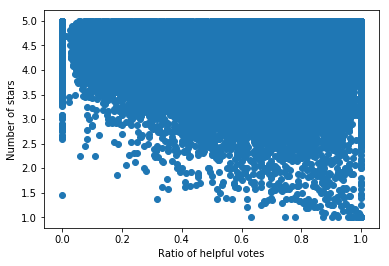

In [13]:
plt.scatter(by_product['ratio_helpful'], by_product['rating'])
plt.xlabel('Ratio of helpful votes')
plt.ylabel('Number of stars')
plt.show()

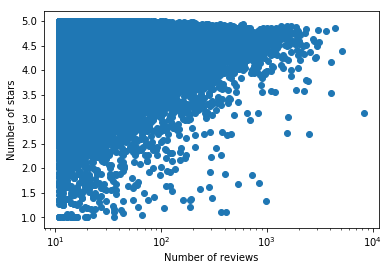

In [14]:
plt.scatter(by_product['n_reviews'], by_product['rating'])
plt.xscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('Number of stars')
plt.show()

In [15]:
by_time = data.select(data['star_rating'],to_timestamp(data['review_date'], 'yyyy-MM-dd').alias('date'), data['review_id'])

In [16]:
by_time_month = by_time.groupby(month('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('month(date)', 'month')
by_time_month.persist()

DataFrame[month: int, count(review_id): bigint, rating: double]

In [17]:
by_time_month = by_time_month.sort("month")

In [18]:
by_time_month.show()

+-----+----------------+------------------+
|month|count(review_id)|            rating|
+-----+----------------+------------------+
| null|            2288| 4.362969752520623|
|    1|         1006324| 4.470198464907923|
|    2|          873022| 4.456938084034538|
|    3|          886006| 4.463014923149505|
|    4|          795696| 4.453070016689791|
|    5|          882266| 4.431156816651668|
|    6|          875895|4.4276711249636085|
|    7|         1012349| 4.443707654178549|
|    8|         1043854| 4.440790570328801|
|    9|          676586| 4.423818997141531|
|   10|          705430| 4.444187233318685|
|   11|          674644| 4.445249642774559|
|   12|          884730| 4.462846292089112|
+-----+----------------+------------------+



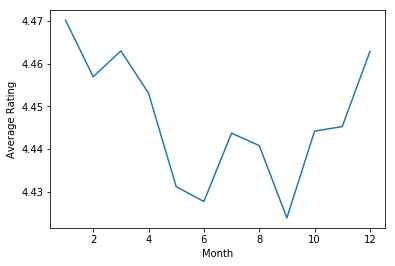

In [19]:
by_month_pd = by_time_month.toPandas()
plt.plot(by_month_pd['month'], by_month_pd['rating'])
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.show()

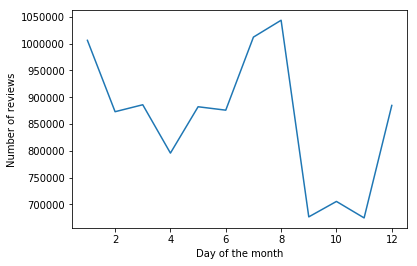

In [20]:
plt.plot(by_month_pd['month'], by_month_pd['count(review_id)'])
plt.xlabel('Day of the month')
plt.ylabel('Number of reviews')
plt.show()

In [21]:
by_time_dayofmonth = by_time.groupby(dayofmonth('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('dayofmonth(date)', 'dayofmonth')
by_time_dayofmonth.persist()

DataFrame[dayofmonth: int, count(review_id): bigint, rating: double]

In [22]:
by_time_dayofmonth = by_time_dayofmonth.sort("dayofmonth")

In [23]:
by_time_dayofmonth.show()

+----------+----------------+------------------+
|dayofmonth|count(review_id)|            rating|
+----------+----------------+------------------+
|      null|            2288| 4.362969752520623|
|         1|          312834| 4.446658611276268|
|         2|          337714| 4.449392089164204|
|         3|          356080|4.4530611098629524|
|         4|          356866| 4.454380635868926|
|         5|          342287| 4.452050472264503|
|         6|          344851| 4.450626502460483|
|         7|          347464| 4.451879906983169|
|         8|          343654| 4.444624535142905|
|         9|          349070| 4.447703898931446|
|        10|          346716| 4.449947507470091|
|        11|          347295|  4.44599259995105|
|        12|          328346|4.4457949845589715|
|        13|          338356| 4.443642199340339|
|        14|          339443| 4.452016980759656|
|        15|          335842|4.4493690485406825|
|        16|          338784| 4.450770992726929|
|        17|        

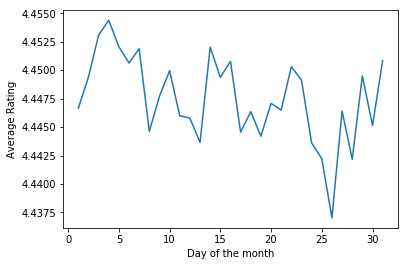

In [24]:
by_dayofmonth_pd = by_time_dayofmonth.toPandas()
plt.plot(by_dayofmonth_pd['dayofmonth'], by_dayofmonth_pd['rating'])
plt.xlabel('Day of the month')
plt.ylabel('Average Rating')
plt.show()

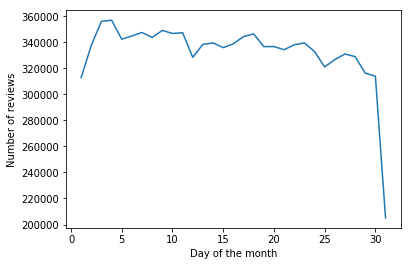

In [25]:
plt.plot(by_dayofmonth_pd['dayofmonth'], by_dayofmonth_pd['count(review_id)'])
plt.xlabel('Day of the month')
plt.ylabel('Number of reviews')
plt.show()

In [26]:
by_time_year = by_time.groupby(year('date')).agg({'star_rating' : 'avg', 'review_id' : 'count'}).withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('year(date)', 'year')
by_time_year.persist()

DataFrame[year: int, count(review_id): bigint, rating: double]

In [27]:
by_time_year = by_time_year.sort("year")

In [28]:
by_time_year.show()

+----+----------------+------------------+
|year|count(review_id)|            rating|
+----+----------------+------------------+
|null|            2288| 4.362969752520623|
|2012|         1132802| 4.333775010990447|
|2013|         2904577| 4.412825344275603|
|2014|         3471693|4.4733457134602626|
|2015|         2807730| 4.497413925128129|
+----+----------------+------------------+



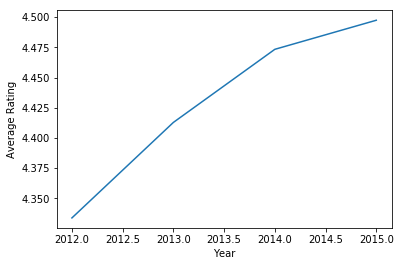

In [29]:
by_year_pd = by_time_year.toPandas()
plt.plot(by_year_pd['year'], by_year_pd['rating'])
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

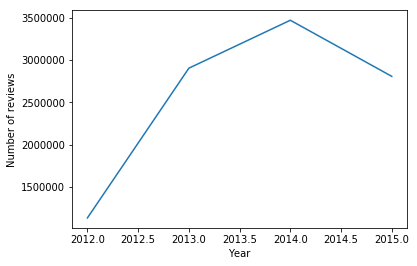

In [30]:
plt.plot(by_year_pd['year'], by_year_pd['count(review_id)'])
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.show()

In [ ]:
div_by_10 = udf(lambda x : 0 if x is None else 10*int(x / 10))
div_by_100 = udf(lambda x : 0 if x is None else 100*int(x / 100))
by_review_length = data.select(data['star_rating'], \
                               div_by_10(length(data['review_headline'])).alias('title_length'), \
                               div_by_100(length(data['review_body'])).alias('body_length'), \
                                      data['review_id'])
by_review_length.persist()

In [32]:
by_review_length.show()

+-----------+------------+-----------+--------------+
|star_rating|title_length|body_length|     review_id|
+-----------+------------+-----------+--------------+
|          5|          10|         30| RJOVP071AVAJO|
|          5|          60|        360|R1ORGBETCDW3AI|
|          5|          10|         50| R7TNRFQAOUTX5|
|          5|          10|         10|R2GANXKDIFZ6OI|
|          5|          10|         80|R2NYB6C3R8LVN6|
|          2|          30|       1500|R13U5PBJI1H94K|
|          5|          50|        740|R1H8UVH990F8VE|
|          5|          10|         10|R2MC0N30WZMRQ5|
|          5|          10|         20| R2NO2HXK16Y4J|
|          5|          10|         30|R245YIAVJK82ZL|
|          5|          10|         10| RFBMLBWQOZ1UM|
|          5|          30|        130| RHE1FEWV3KTQH|
|          5|          10|         20|R2BB9U7PHO7ETO|
|          4|          10|         20|R28XJJP754GYXO|
|          3|          70|        270|R2G519UREHRO8M|
|          5|          10|  

In [33]:

by_title_length = by_review_length.groupby('title_length').agg({'star_rating':'avg', 'review_id':'count'}).\
                    withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_title_length.persist()

DataFrame[title_length: string, count: bigint, rating: double]

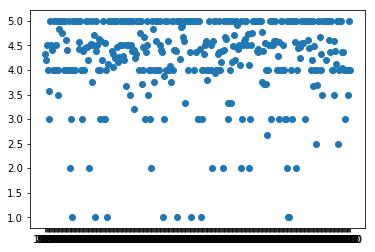

In [34]:
by_title_length_pd = by_title_length.toPandas()
by_title_length_pd
plt.scatter(by_title_length_pd['title_length'], by_title_length_pd['rating'])

In [35]:
by_body_length = by_review_length.groupby('body_length').agg({'star_rating':'avg', 'review_id':'count'}) \
                    .withColumnRenamed('avg(star_rating)', 'rating').withColumnRenamed('count(review_id)', 'count')
by_body_length.persist()

DataFrame[body_length: string, count: bigint, rating: double]

In [ ]:
by_body_length.count()

In [ ]:
by_body_length_pd = by_body_length.toPandas()
by_body_length_pd
plt.plot(by_body_length_pd['body_length'], by_body_length_pd['count'])

2